# Multilayer Perceptron - Group 86

Importing Libraries

In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Common funcion definitions

In [0]:
#Vectorize the dataset into flat array
def vectorize_data(dataset):
    x = np.array(dataset.data)
    number_features = x.shape[1]*x.shape[2]*x.shape[3]
    x= x.reshape(x.shape[0], number_features)
    x =x.astype('float32')
    scaler = StandardScaler().fit(x)
    x_scaled = scaler.transform(x)
    y = np.array(dataset.targets)
    y = y.reshape(y.shape[0],1)
    return x_scaled,y 

#Cross entropy cost funciton
def cost_function(y_pred, y_actual):
    return log_loss(y_actual,y_pred)

#Create mini batches for SGD
def create_mini_batches (x_train, y_train, N, batch_size):
    
    data = np.c_[x_train.reshape(len(x_train), -1), y_train.reshape(len(y_train), -1)]
    np.random.shuffle (data)
    x = data[:, :x_train.size//len(x_train)].reshape(x_train.shape)
    y = data[:, x_train.size//len(x_train):].reshape(y_train.shape)
    
    mini_batches_x = [x[k:k+batch_size] 
                      for k in range(0,N,batch_size)]

    mini_batches_y = [y[k:k+batch_size] 
                      for k in range(0,N,batch_size)]
    
    return mini_batches_x, mini_batches_y
    
#One-Hot Encoding
def encode_one_hot(y, N):
    oh_encode = OneHotEncoder(sparse=False,categories='auto')
    y = y.reshape(N,1)
    y = oh_encode.fit_transform(y)
    return y

#ReLU activation funciton
def relu(z):
    a = np.maximum(0,z)
    return a

#Derivative of Relu activation funciton
def relu_derivative(z):
    da_dz = np.where (z>0,1,0)
    return da_dz

#Softmax function
def softmax(z):
    x = np.exp(z-np.max(z,axis = 1,keepdims = True))
    sums = np.sum(x,axis = 1,keepdims = True)
    y = x/(sums)
    return y 

MLP Algorithm implementation

In [0]:
class MLP (object):
    def __init__(self,input_dim,hidden_layer,output_dim):
        self.neurons = [input_dim,hidden_layer,output_dim]
        self.total_layers = len(hidden_layer)+2
        self.weights = []
        self.biases = []
        #Initialize weights with mean 0 and SD=1/sq-root(D)
        W1 = np.random.normal(0,1/np.sqrt(input_dim),size =(input_dim,hidden_layer[0]))
        self.weights.append(W1)
        
        for layer in range(len(hidden_layer)-1):
            W1 = np.random.normal(0,1/np.sqrt(hidden_layer[layer]),size =(hidden_layer[layer],hidden_layer[layer+1]))
            self.weights.append(W1)
        
        W1 = np.random.normal(0,1/np.sqrt(hidden_layer[-1]),size =(hidden_layer[-1],output_dim))        
        self.weights.append(W1)
        #Initialize bias with mean 0 and SD=1
        for layer in range(len(hidden_layer)):
            b1 = np.random.normal(0,1,size =(1, hidden_layer[layer]))
            self.biases.append(b1)
        
        b1 = np.random.normal(0,1,size =(1, output_dim))
        self.biases.append(b1)
        
    #Feed Forward in the Neural Network    
    def feed_forward(self,x, verbose=False):
        a_list = []
        z_list = []
        a_list.append(x)
    
        for layer in range (self.total_layers-1):        
            z = np.dot(a_list[layer],self.weights[layer])+self.biases[layer]
            if (layer != (self.total_layers-2)): #Use ReLu for input and hidden layers
                a = relu(z)
            else: #Use softmax for output layer
                y = softmax(z)
            z_list.append(z)
            a_list.append(a)
        
        if verbose == True: #Return all the activation data in hidden layer if requested
            return a_list, z_list, y
        else:
            return y
    
    #Back propogation algorithm
    def back_propagation(self,y_pred, y_actual, a_list,z_list):
    
        dc_dw = [0 for i in range(self.total_layers-1)]
        dc_db = [0 for i in range(self.total_layers-1)]

        #Final Layer
        dc_dz = y_pred - y_actual
        dc_dw[-1] = np.dot(a_list[-1].T,dc_dz)
        dc_db[-1] = np.sum(dc_dz, axis = 0, keepdims=True)
        #Remaining Layers
        for layer in range ((self.total_layers-1),1,-1):
            da_dz = relu_derivative(z_list[layer-2])
            dc_da = np.dot(dc_dz,self.weights[layer-1].T)
            dc_dz = dc_da*da_dz
            dc_dw[layer-2] = np.dot(a_list[layer-2].T, dc_dz)
            dc_db[layer-2] = np.sum(dc_dz, axis = 0, keepdims=True)    
        
        return dc_dw,dc_db 
    
    #Stohastic Gradient descent with L2 regularization
    def sgd(self,dc_dw,dc_db,lr,ridge, N):
 
        for layer in range(self.total_layers-1):
            self.weights[layer] = ((1 - lr*(ridge/N))*self.weights[layer]) - lr*dc_dw[layer]
            self.biases[layer] -= (lr)*dc_db[layer]

    #Train the model    
    def fit(self,x_train, y_train, lr, epochs,ridge, batch_size):
    
        N, D = x_train.shape
        y_oh = encode_one_hot(y_train, N)
        iters = (N/batch_size)
        cost_array = []
        decay = 0
        for eps in range(epochs):
            #Minibatch   
            batches_x, batches_y = create_mini_batches (x_train, y_oh, N, batch_size)
            
            for x_train_mini,y_oh_mini in zip (batches_x, batches_y):
                #Feed Forward:
                a_list,z_list, y_pred = self.feed_forward(x_train_mini, verbose=True)
                #Backpropagation:
                dC_dw, dC_db = self.back_propagation(y_pred, y_oh_mini, a_list,z_list)                
                #SGD with minibatch
                self.sgd(dC_dw, dC_db,lr,ridge, N)
                    
        #Training Accuracy and cost
        y_predicted = self.feed_forward(x_train)
        cost = cost_function (y_predicted,y_oh)
        y_predicted = (np.argmax(y_predicted, axis = 1)).reshape(N,1)
        accuracy = np.mean(y_predicted == y_train)
        print ("cost:",cost)
        print("Train data accuracy:", accuracy*100, "%")
        return accuracy, cost
    
    #Predict
    def predict(self,x_test):
        N, D = x_test.shape
        y_predicted = self.feed_forward(x_test)
        y_predicted = (np.argmax(y_predicted, axis = 1)).reshape(N, 1)
        return y_predicted

Upload data and vectorize

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

x_train, y_train = vectorize_data(trainset)
x_test, y_test = vectorize_data(testset)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Train and Test the model with CIFAR-10 dataset

In [0]:
hidden_layers = np.array([512,512])
lr = 0.0001
batch_size = 50
epochs = 20
ridge = 0.4
N,C = x_train.shape
N_train = int(N*0.8)
nnet = MLP(x_train.shape[1],hidden_layers,np.unique(y_train).size)
y_train_predicted, cost = nnet.fit(x_train[:N_train], y_train[:N_train], lr, epochs,ridge, batch_size)
y_validate = nnet.predict(x_train[N_train:])
y_predicted = nnet.predict(x_test)

validation_accuracy = np.mean(y_validate == y_train[N_train:])
print("validation data accuracy:", validation_accuracy*100, "%") 
test_accuracy = np.mean(y_predicted == y_test)
print("Test data accuracy:", test_accuracy*100, "%")

cost: 0.7244203867277912
Train data accuracy: 75.7675 %
validation data accuracy: 52.99 %
Test data accuracy: 52.54 %


Epoch vs Accuracy

In [0]:
hidden_layers = np.array([512, 512])
lr = 0.0001
batch_size = 50
epoch_array = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ridge = 0.4

cost_v = []
train_accuracy_v = []
test_accuracy_v = []
validation_accuracy_v = []

N,C = x_train.shape
N_train = int(N*0.8)

for epochs in epoch_array:
    print ("Epochs: ",epochs)
    n_net = MLP(x_train.shape[1],hidden_layers,np.unique(y_train).size)
    train_accuracy, cost = n_net.fit(x_train[:N_train], y_train[:N_train], lr, epochs,ridge, batch_size)
    y_validate = n_net.predict(x_train[N_train:])
    y_predicted = n_net.predict(x_test)

    validation_accuracy = np.mean(y_validate == y_train[N_train:])
    print("validation data accuracy:", validation_accuracy*100, "%") 
    test_accuracy = np.mean(y_predicted == y_test)
    print("Test data accuracy:", test_accuracy*100, "%")
    print ("\n")

    cost_v.append(cost)
    train_accuracy_v.append(train_accuracy)
    validation_accuracy_v.append(validation_accuracy)
    test_accuracy_v.append(test_accuracy)
    

Epochs:  1
cost: 1.620872442559025
Train data accuracy: 42.8825 %
validation data accuracy: 40.64 %
Test data accuracy: 41.43 %


Epochs:  2
cost: 1.4933606107636794
Train data accuracy: 47.5375 %
validation data accuracy: 44.89 %
Test data accuracy: 45.08 %


Epochs:  3
cost: 1.4071741706469716
Train data accuracy: 51.080000000000005 %
validation data accuracy: 46.64 %
Test data accuracy: 47.22 %


Epochs:  4
cost: 1.3553641711605617
Train data accuracy: 52.395 %
validation data accuracy: 47.589999999999996 %
Test data accuracy: 48.370000000000005 %


Epochs:  5
cost: 1.2956290304421345
Train data accuracy: 54.9875 %
validation data accuracy: 48.55 %
Test data accuracy: 49.65 %


Epochs:  6
cost: 1.2531281740832094
Train data accuracy: 56.36750000000001 %
validation data accuracy: 49.53 %
Test data accuracy: 49.72 %


Epochs:  7
cost: 1.211068016726883
Train data accuracy: 57.942499999999995 %
validation data accuracy: 50.17 %
Test data accuracy: 50.09 %


Epochs:  8
cost: 1.142390938

Hidden Layer Width vs Accuracy

Epochs vs Cost


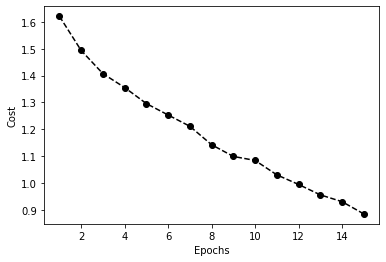

Epochs vs Accuracy


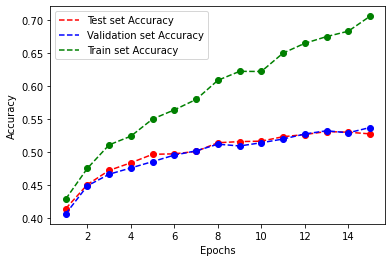

In [0]:
print ("Epochs vs Cost")
plt.plot(np.array(epoch_array),np.array(cost_v), 'ko',np.array(epoch_array),np.array(cost_v), 'k--')
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

print ("Epochs vs Accuracy")
plt.plot(epoch_array,test_accuracy_v, 'ro')
plt.plot(epoch_array,test_accuracy_v, 'r--', label = 'Test set Accuracy')
plt.plot(epoch_array,validation_accuracy_v, 'bo')
plt.plot(epoch_array,validation_accuracy_v, 'b--', label = 'Validation set Accuracy')
plt.plot(epoch_array,train_accuracy_v, 'go')
plt.plot(epoch_array,train_accuracy_v, 'g--',label = 'Train set Accuracy')
plt.legend(frameon=True)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [0]:
hl1 = np.array([32, 32])
hl2 = np.array([64, 64])
hl3 = np.array([128, 128])
hl4 = np.array([256, 256])
hl5 = np.array([512, 512])
hl6 = np.array([1024, 1024])
hl7 = np.array([2048, 2048])
hl_array = [hl1,hl2,hl3,hl4,hl5,hl6,hl7]
lr = 0.0001
batch_size = 50
epochs = 20
ridge = 0.4

cost_v1 = []
train_accuracy_v1 = []
test_accuracy_v1 = []
validation_accuracy_v1 = []

for hidden_layers in hl_array:
    print ("Hidden Layers: ",hidden_layers)
    n_net = MLP(x_train.shape[1],hidden_layers,np.unique(y_train).size)
    train_accuracy, cost = n_net.fit(x_train[:N_train], y_train[:N_train], lr, epochs,ridge, batch_size)
    y_validate = n_net.predict(x_train[N_train:])
    y_predicted = n_net.predict(x_test)

    validation_accuracy = np.mean(y_validate == y_train[N_train:])
    print("validation data accuracy:", validation_accuracy*100, "%") 
    test_accuracy = np.mean(y_predicted == y_test)
    print("Test data accuracy:", test_accuracy*100, "%")
    print ("\n")
    cost_v1.append(cost)
    train_accuracy_v1.append(train_accuracy)
    validation_accuracy_v1.append(validation_accuracy)
    test_accuracy_v1.append(test_accuracy)


Hidden Layers:  [32 32]
cost: 1.2577609446802438
Train data accuracy: 55.625 %
validation data accuracy: 47.65 %
Test data accuracy: 47.85 %


Hidden Layers:  [64 64]
cost: 1.1041758763750813
Train data accuracy: 61.432500000000005 %
validation data accuracy: 50.24999999999999 %
Test data accuracy: 49.97 %


Hidden Layers:  [128 128]
cost: 0.9484211719833656
Train data accuracy: 67.325 %
validation data accuracy: 52.1 %
Test data accuracy: 51.65 %


Hidden Layers:  [256 256]
cost: 0.8290778252673546
Train data accuracy: 72.245 %
validation data accuracy: 52.66 %
Test data accuracy: 52.66 %


Hidden Layers:  [512 512]
cost: 0.7178081666818933
Train data accuracy: 76.8525 %
validation data accuracy: 53.059999999999995 %
Test data accuracy: 52.59 %


Hidden Layers:  [1024 1024]
cost: 0.5909694249232
Train data accuracy: 82.22749999999999 %
validation data accuracy: 54.85 %
Test data accuracy: 53.290000000000006 %


Hidden Layers:  [2048 2048]
cost: 0.5179111906737055
Train data accuracy: 

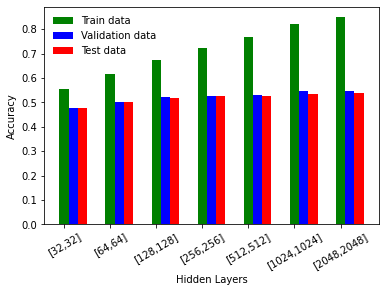

In [0]:
index = ['[32,32]','[64,64]','[128,128]','[256,256]','[512,512]','[1024,1024]','[2048,2048]']
groups = len(index)
width = 0.2
plt.bar(np.arange(groups),train_accuracy_v1,width,color = 'green', label = 'Train data')
plt.bar(np.arange(groups)+width,validation_accuracy_v1,width,color = 'blue', label = 'Validation data')
plt.bar(np.arange(groups)+(width*2),test_accuracy_v1,width,color = 'red', label = 'Test data')
plt.xlabel('Hidden Layers')
plt.ylabel('Accuracy')
plt.xticks(np.arange(groups),index,rotation=30)
plt.legend(frameon=False)
plt.show()

Hidden Layer depth vs Accuracy

In [0]:
hl1 = np.array([16])
hl2 = np.array([32,32])
hl3 = np.array([64,64,64])
hl4 = np.array([128,128,128,128])

hl_array = [hl1,hl2,hl3,hl4]
lr = 0.0001
batch_size = 50
epochs = 20
ridge = 0.4

cost_v2 = []
train_accuracy_v2 = []
test_accuracy_v2 = []
validation_accuracy_v2 = []

for hidden_layers in hl_array:
    print ("Hidden Layers: ",hidden_layers)
    n_net = MLP(x_train.shape[1],hidden_layers,np.unique(y_train).size)
    train_accuracy, cost = n_net.fit(x_train[:N_train], y_train[:N_train], lr, epochs,ridge, batch_size)
    y_validate = n_net.predict(x_train[N_train:])
    y_predicted = n_net.predict(x_test)

    validation_accuracy = np.mean(y_validate == y_train[N_train:])
    print("validation data accuracy:", validation_accuracy*100, "%") 
    test_accuracy = np.mean(y_predicted == y_test)
    print("Test data accuracy:", test_accuracy*100, "%")
    print("\n")
    cost_v2.append(cost)
    train_accuracy_v2.append(train_accuracy)
    validation_accuracy_v2.append(validation_accuracy)
    test_accuracy_v2.append(test_accuracy)

Hidden Layers:  [16]
cost: 1.4349516628799948
Train data accuracy: 49.88 %
validation data accuracy: 43.96 %
Test data accuracy: 44.07 %


Hidden Layers:  [32 32]
cost: 1.2788722731781215
Train data accuracy: 55.175 %
validation data accuracy: 46.93 %
Test data accuracy: 47.12 %


Hidden Layers:  [64 64 64]
cost: 1.099938379434535
Train data accuracy: 61.17 %
validation data accuracy: 49.58 %
Test data accuracy: 50.129999999999995 %


Hidden Layers:  [128 128 128 128]
cost: 0.9166078409438992
Train data accuracy: 68.0725 %
validation data accuracy: 51.03 %
Test data accuracy: 50.980000000000004 %




Using Leaky ReLU and Sigmoid activation function

In [0]:
def leaky_relu(z):
    a = np.where (z>0,z,0.01*z)
    return a

def sigmoid(z):
    a = 1/(1+np.exp(-z))
    return a

def sigmoid_derivative(z):
    da_dz = sigmoid(z)*(1-sigmoid(z)) 
    return da_dz

def leaky_relu_derivative(z):
    da_dz = np.where (z>0,1,0)
    return da_dz

def activation_function(z,activation):
    if (activation == "leaky relu"):
        return leaky_relu(z)
    elif (activation == "sigmoid"):
        return sigmoid(z)
    else:
        return 0

def activation_derivative(z,activation):
    if (activation == "leaky relu"):
        return leaky_relu_derivative(z)
    elif (activation == "sigmoid"):
        return sigmoid_derivative(z)
    else:
        return 0

class MLP (object):
    def __init__(self,input_dim,hidden_layer,output_dim):
        self.neurons = [input_dim,hidden_layer,output_dim]
        self.total_layers = len(hidden_layer)+2
        self.weights = []
        self.biases = []
        self.activation = 0

        W1 = np.random.normal(0,1/np.sqrt(input_dim),size =(input_dim,hidden_layer[0]))
        self.weights.append(W1)
        
        for layer in range(len(hidden_layer)-1):
            W1 = np.random.normal(0,1/np.sqrt(hidden_layer[layer]),size =(hidden_layer[layer],hidden_layer[layer+1]))
            self.weights.append(W1)
        
        W1 = np.random.normal(0,1/np.sqrt(hidden_layer[-1]),size =(hidden_layer[-1],output_dim))        
        self.weights.append(W1)
        
        for layer in range(len(hidden_layer)):
            b1 = np.random.normal(0,1,size =(1, hidden_layer[layer]))
            self.biases.append(b1)
        
        b1 = np.random.normal(0,1,size =(1, output_dim))
        self.biases.append(b1)
        
    def feed_forward(self,x, verbose=False):
        a_list = []
        z_list = []
        a_list.append(x)
    
        for layer in range (self.total_layers-1):        
            z = np.dot(a_list[layer],self.weights[layer])+self.biases[layer]
            if (layer != (self.total_layers-2)):
                a = activation_function(z,self.activation)
            else:
                y = softmax(z)
            z_list.append(z)
            a_list.append(a)
        
        if verbose == True:
            return a_list, z_list, y
        else:
            return y
    
    def back_propagation(self,y_pred, y_actual, a_list,z_list):
    
        dc_dw = [0 for i in range(self.total_layers-1)]
        dc_db = [0 for i in range(self.total_layers-1)]

        #Final Layer
        dc_dz = y_pred - y_actual
        dc_dw[-1] = np.dot(a_list[-1].T,dc_dz)
        dc_db[-1] = np.sum(dc_dz, axis = 0, keepdims=True)
        #Remaining Layers
        for layer in range ((self.total_layers-1),1,-1):
            da_dz = activation_derivative(z_list[layer-2],self.activation)
            dc_da = np.dot(dc_dz,self.weights[layer-1].T)
            dc_dz = dc_da*da_dz
            dc_dw[layer-2] = np.dot(a_list[layer-2].T, dc_dz)
            dc_db[layer-2] = np.sum(dc_dz, axis = 0, keepdims=True)    
        
        return dc_dw,dc_db 
    
    def sgd(self,dc_dw,dc_db,lr,ridge, N):
 
        for layer in range(self.total_layers-1):
            self.weights[layer] = ((1 - lr*(ridge/N))*self.weights[layer]) - lr*dc_dw[layer]
            self.biases[layer] -= (lr)*dc_db[layer]
        
    def fit(self,x_train, y_train, lr, epochs,ridge, batch_size, activation):
    
        N, D = x_train.shape
        y_oh = encode_one_hot(y_train, N)
        iters = (N/batch_size)
        cost_array = []
        self.activation = activation
        decay = 0
        for eps in range(epochs):
            #Minibatch selection:
            #x_train_mini, y_oh_mini, N_mini = SGD_minibatch(x_train, y_oh, N, batch_size)   
            batches_x, batches_y = create_mini_batches (x_train, y_oh, N, batch_size)
            
            for x_train_mini,y_oh_mini in zip (batches_x, batches_y):
                #Feed Forward:
                a_list,z_list, y_pred = self.feed_forward(x_train_mini, verbose=True)
                
                #Backpropagation:
                dC_dw, dC_db = self.back_propagation(y_pred, y_oh_mini, a_list,z_list)
                
                #SGD w/ momentum and minibatch
                self.sgd(dC_dw, dC_db,lr,ridge, N)
                    
        #Training Accuracy:
        y_predicted = self.feed_forward(x_train)
        cost = cost_function (y_predicted,y_oh)
        y_predicted = (np.argmax(y_predicted, axis = 1)).reshape(N,1)
        accuracy = np.mean(y_predicted == y_train)
        print ("cost:",cost)
        print("Train data accuracy:", accuracy*100, "%")
        return accuracy, cost
    
    def predict(self,x_test):
        N, D = x_test.shape
        y_predicted = self.feed_forward(x_test)
        y_predicted = (np.argmax(y_predicted, axis = 1)).reshape(N, 1)
        return y_predicted

In [0]:
hidden_layers = np.array([512, 512])
lr = 0.0001
batch_size = 50
epoch_array = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
ridge = 0.4
activation = "leaky relu"
cost_v3 = []
train_accuracy_v3 = []
test_accuracy_v3 = []
validation_accuracy_v3 = []

N,C = x_train.shape
N_train = int(N*0.8)

for epochs in epoch_array:
    print ("Epochs: ",epochs)
    n_net = MLP(x_train.shape[1],hidden_layers,np.unique(y_train).size)
    train_accuracy, cost = n_net.fit(x_train[:N_train], y_train[:N_train], lr, epochs,ridge, batch_size, activation)
    y_validate = n_net.predict(x_train[N_train:])
    y_predicted = n_net.predict(x_test)

    validation_accuracy = np.mean(y_validate == y_train[N_train:])
    print("validation data accuracy:", validation_accuracy*100, "%") 
    test_accuracy = np.mean(y_predicted == y_test)
    print("Test data accuracy:", test_accuracy*100, "%")
    print ("\n")

    cost_v3.append(cost)
    train_accuracy_v3.append(train_accuracy)
    validation_accuracy_v3.append(validation_accuracy)
    test_accuracy_v3.append(test_accuracy)

activation = "sigmoid"
cost_v4 = []
train_accuracy_v4 = []
test_accuracy_v4 = []
validation_accuracy_v4 = []

for epochs in epoch_array:
    print ("Epochs: ",epochs)
    n_net = MLP(x_train.shape[1],hidden_layers,np.unique(y_train).size)
    train_accuracy, cost = n_net.fit(x_train[:N_train], y_train[:N_train], lr, epochs,ridge, batch_size, activation)
    y_validate = n_net.predict(x_train[N_train:])
    y_predicted = n_net.predict(x_test)

    validation_accuracy = np.mean(y_validate == y_train[N_train:])
    print("validation data accuracy:", validation_accuracy*100, "%") 
    test_accuracy = np.mean(y_predicted == y_test)
    print("Test data accuracy:", test_accuracy*100, "%")
    print ("\n")

    cost_v4.append(cost)
    train_accuracy_v4.append(train_accuracy)
    validation_accuracy_v4.append(validation_accuracy)
    test_accuracy_v4.append(test_accuracy)

Epochs:  1
cost: 1.6051284855398587
Train data accuracy: 43.6325 %
validation data accuracy: 41.47 %
Test data accuracy: 42.8 %


Epochs:  2
cost: 1.4928514438082514
Train data accuracy: 47.972500000000004 %
validation data accuracy: 44.15 %
Test data accuracy: 45.4 %


Epochs:  3
cost: 1.4182933149886912
Train data accuracy: 50.595 %
validation data accuracy: 46.489999999999995 %
Test data accuracy: 46.68 %


Epochs:  4
cost: 1.3373561310566955
Train data accuracy: 53.6025 %
validation data accuracy: 48.24 %
Test data accuracy: 48.84 %


Epochs:  5
cost: 1.2948788838158447
Train data accuracy: 54.972500000000004 %
validation data accuracy: 49.3 %
Test data accuracy: 48.72 %


Epochs:  6
cost: 1.2595929133800756
Train data accuracy: 56.155 %
validation data accuracy: 49.370000000000005 %
Test data accuracy: 50.239999999999995 %


Epochs:  7
cost: 1.2065323799750063
Train data accuracy: 58.037499999999994 %
validation data accuracy: 50.239999999999995 %
Test data accuracy: 50.68 %


Epo

Epochs vs Accuracy


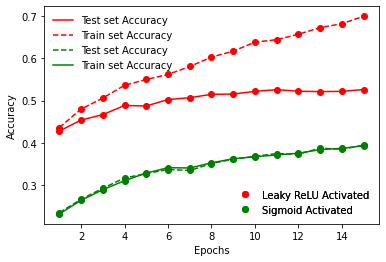

In [0]:
print ("Epochs vs Accuracy")
p1, = plt.plot(epoch_array,test_accuracy_v3, 'ro')
p2, = plt.plot(epoch_array,test_accuracy_v3, 'r-')
p3, = plt.plot(epoch_array,train_accuracy_v3, 'ro')
p4, = plt.plot(epoch_array,train_accuracy_v3, 'r--')

p5, = plt.plot(epoch_array,test_accuracy_v4, 'go')
p6, = plt.plot(epoch_array,test_accuracy_v4, 'g--')
p7, = plt.plot(epoch_array,train_accuracy_v4, 'go')
p8, = plt.plot(epoch_array,train_accuracy_v4, 'g-')

leg1 = [p1,p5]
leg2 = [p2,p4,p6,p8]

legend2 = plt.legend(leg2, ["Test set Accuracy", "Train set Accuracy", "Test set Accuracy","Train set Accuracy"], loc = 2,frameon=False)
legend1 = plt.legend(leg1, ["Leaky ReLU Activated","Sigmoid Activated"], loc = 4, frameon=False)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()